In [166]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/acea-water-prediction/Aquifer_Doganella.csv
/kaggle/input/acea-water-prediction/Aquifer_Auser.csv
/kaggle/input/acea-water-prediction/Water_Spring_Amiata.csv
/kaggle/input/acea-water-prediction/datasets_description.ods
/kaggle/input/acea-water-prediction/Lake_Bilancino.csv
/kaggle/input/acea-water-prediction/datasets_description.xlsx
/kaggle/input/acea-water-prediction/Water_Spring_Madonna_di_Canneto.csv
/kaggle/input/acea-water-prediction/Aquifer_Luco.csv
/kaggle/input/acea-water-prediction/Aquifer_Petrignano.csv
/kaggle/input/acea-water-prediction/Water_Spring_Lupa.csv
/kaggle/input/acea-water-prediction/River_Arno.csv


In [167]:
# place each CSV into it's own data frame since I am trying to predict each body of water flow, volume, and/or hydrometry seperately
Aquifer_Auser = pd.read_csv('../input/acea-water-prediction/Aquifer_Auser.csv')
Aquifer_Doganella = pd.read_csv('../input/acea-water-prediction/Aquifer_Doganella.csv')
Aquifer_Luco = pd.read_csv('../input/acea-water-prediction/Aquifer_Luco.csv')
Aquifer_Petrignano = pd.read_csv('../input/acea-water-prediction/Aquifer_Petrignano.csv')
Lake_Bilancino = pd.read_csv('../input/acea-water-prediction/Lake_Bilancino.csv')
River_Arno = pd.read_csv('../input/acea-water-prediction/River_Arno.csv')
Water_Spring_Amiata = pd.read_csv('../input/acea-water-prediction/Water_Spring_Amiata.csv')
Water_Spring_Lupa = pd.read_csv('../input/acea-water-prediction/Water_Spring_Lupa.csv')
Water_Spring_Madonna_di_Canneto = pd.read_csv('../input/acea-water-prediction/Water_Spring_Madonna_di_Canneto.csv')

# Then print the shape of each DF to look for where I should start analysis (start small work up)

print(f"Water_Spring_Madonna_di_Canneto:{Water_Spring_Madonna_di_Canneto.shape},\nWater_Spring_Lupa:{Water_Spring_Lupa.shape},\nWater_Spring_Amiata:{Water_Spring_Amiata.shape},\nRiver_Arno:{River_Arno.shape},\nLake_Bilancino:{Lake_Bilancino.shape},\nAquifer_Petrignano:{Aquifer_Petrignano.shape},\nAquifer_Luco:{Aquifer_Luco.shape}, \nAquifer_Doganella:{Aquifer_Doganella.shape},\nAquifer_Auser:{Aquifer_Auser.shape}")

Water_Spring_Madonna_di_Canneto:(3113, 4),
Water_Spring_Lupa:(4199, 3),
Water_Spring_Amiata:(7487, 16),
River_Arno:(8217, 17),
Lake_Bilancino:(6603, 9),
Aquifer_Petrignano:(5223, 8),
Aquifer_Luco:(7487, 22), 
Aquifer_Doganella:(6026, 22),
Aquifer_Auser:(8154, 27)


After looking at the shape of each DF I will start with Water_Spring_Lupa as it has the least amount of features to work with. Let's start by looking at the basics of the data looking at descirption, columns, trying to find distributions, etc

In [168]:
Water_Spring_Lupa.columns

Index(['Date', 'Rainfall_Terni', 'Flow_Rate_Lupa'], dtype='object')

In [169]:
Water_Spring_Lupa.describe()

,Rainfall_Terni,Flow_Rate_Lupa
count,4199.000000,3817.000000
mean,2.466355,-97.712916
std,2.041837,15.026314
min,0.000000,-182.310000
25%,1.402000,-105.760000
50%,2.142000,-96.590000
75%,3.165000,-87.220000
max,76.000000,0.000000


In [170]:
Water_Spring_Lupa.dtypes

Date               object
Rainfall_Terni    float64
Flow_Rate_Lupa    float64
dtype: object

In [171]:
print(Water_Spring_Lupa.isnull().sum()/Water_Spring_Lupa.shape[0] * 100)
print()
print(f"Number of missing Flow_Rate_Lupa values: {Water_Spring_Lupa['Flow_Rate_Lupa'].isnull().sum()/Water_Spring_Lupa.shape[0] * Water_Spring_Lupa.shape[0]}")


Date              0.000000
Rainfall_Terni    0.000000
Flow_Rate_Lupa    9.097404
dtype: float64

Number of missing Flow_Rate_Lupa values: 382.0


Less than 10% of the target variable data is missing. However, due to this problem being a time series problem, we do not want to drop the null values Imputing the null values for the target variable can be tricky and cause issues.  My current assumption is that there is seaonalility AND trend present in the data. Let's explore further.

In [172]:
Water_Spring_Lupa['Date']

0       01/01/2009
1       02/01/2009
2       03/01/2009
3       04/01/2009
4       05/01/2009
           ...    
4194    26/06/2020
4195    27/06/2020
4196    28/06/2020
4197    29/06/2020
4198    30/06/2020
Name: Date, Length: 4199, dtype: object

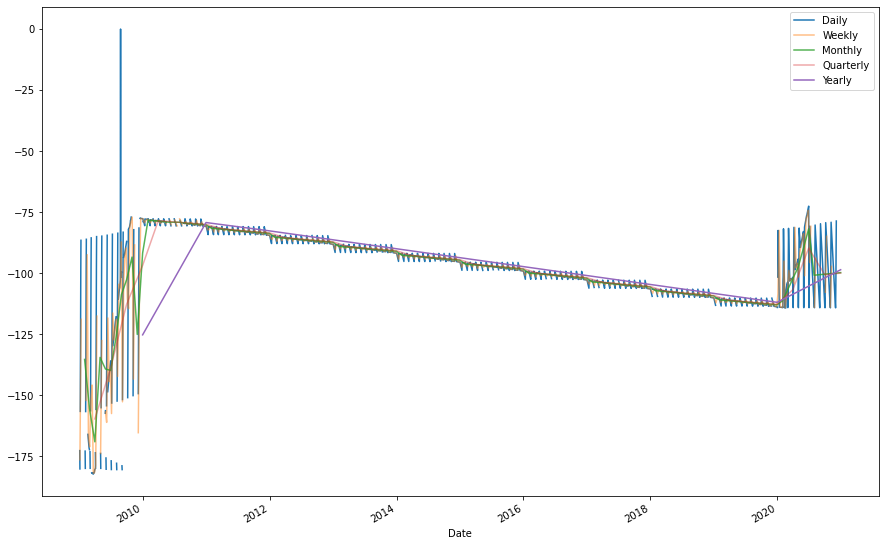

In [173]:
# First we need to convert the date object into a datetime object
Water_Spring_Lupa['Date'] = pd.to_datetime(Water_Spring_Lupa['Date'])
# Then we need to sort the index by date and assign it to the the index
Water_Spring_Lupa = Water_Spring_Lupa.sort_values(by='Date')
Water_Spring_Lupa.set_index('Date', inplace = True)

# Finally, let's look at the flow rate(target variable) in at different time intervals. Since we are looking at a usage metric, mean is the best aggreation.
plt.figure(figsize=(15,10))
Water_Spring_Lupa['Flow_Rate_Lupa'].plot(label='Daily')
Water_Spring_Lupa['Flow_Rate_Lupa'].resample('W').mean().plot(alpha=.5, label='Weekly')
Water_Spring_Lupa['Flow_Rate_Lupa'].resample('M').mean().plot(alpha=.8, label='Monthly')
Water_Spring_Lupa['Flow_Rate_Lupa'].resample('Q').mean().plot(alpha=.4, label='Quarterly')
Water_Spring_Lupa['Flow_Rate_Lupa'].resample('Y').mean().plot(label='Yearly')
plt.legend()

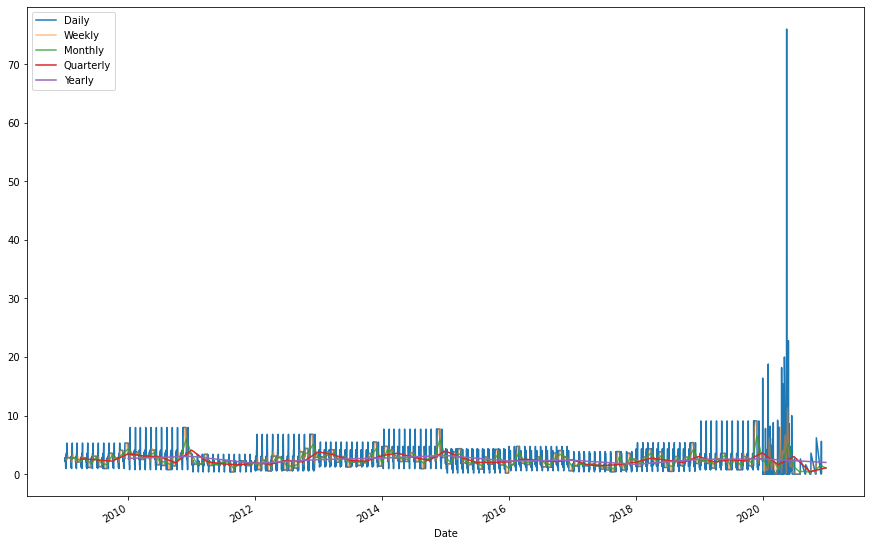

In [174]:
# let's look at the rainfall in different break downs
plt.figure(figsize=(15,10))
Water_Spring_Lupa['Rainfall_Terni'].plot(label='Daily')
Water_Spring_Lupa['Rainfall_Terni'].resample('W').mean().plot(alpha=.5, label='Weekly')
Water_Spring_Lupa['Rainfall_Terni'].resample('M').mean().plot(alpha=.8, label='Monthly')
Water_Spring_Lupa['Rainfall_Terni'].resample('Q').mean().plot(label='Quarterly')
Water_Spring_Lupa['Rainfall_Terni'].resample('Y').mean().plot(label='Yearly')
plt.legend()